# End-to-end Walkthrough of SPTAG 



The following notebook is a guide on how to run SPTAG on your custom vector dataset. 

## Table of Contents
1. Example 1 - Using randomly generated vectors
2. Example 2 - Using the Caltech 101 Image Dataset

For the following walkthrough, it is assumed that SPTAG is installed.

First of all, let's install the required pip modules for this walkthrough example. 

In [ ]:
import sys

# Install pip packages in the current Jupyter kernel
!{sys.executable} -m pip install -r requirements.txt

# IF you are using a GPU machine, uncomment and run the below
# !{sys.executable} -m pip install tensorflow-gpu

# If not, then uncomment and run the below
# !{sys.executable} -m pip install tensorflow

Now, we will import the required modules.

In [1]:
import SPTAG

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import time

%matplotlib inline

SPTAG assumes the samples are represented as vectors. We need two vectors:
- arr for the database, that contains all the vectors that must be indexed, and that we are going to search in. 
- xq for the query vectors, for which we need to find the nearest neighbors.

In the first example, vectors will be drawn form a uniform distribution in d=2 dimensions. The second example uses images to create the vectors.

## Example 1: Using Randomly Generated Vectors

### Generate Random Dataset and Query Vector

As a most basic example of how to run SPTAG over vectors, we will randomly generate the vectors and build the index using this. 

In [8]:
d = 2                           # dimension
nb = 100                      # dataset size
nq = 1                     # nb of queries
np.random.seed(1234)             # make reproducible

randomData = np.random.random((nb, d)).astype('float32')
randomData.shape

(100, 2)

Select a query vector to use for testing against our built index later on.

In [9]:
xq = arr[1:2] # The query vector
k = 5 # Number of results to return, in this case the 5 most similar results

### Define Functions for Building and Searching over Indices

In [2]:
def testBuild(algo, distmethod, x, out):
    '''
    Build indices from vectors
    
    Parameters: 
           algo (str): Graph algorithm ('BKT' or 'KDT'). 
           distmethod (str): Distance comparison method. ('L2' or 'Cosine')
           x (array): Vectors to index
           out (str): Name of output directory to save index to
    '''
    i = SPTAG.AnnIndex(algo, 'Float', x.shape[1])
    i.SetBuildParam("NumberOfThreads", '4')
    i.SetBuildParam("DistCalcMethod", distmethod)
    ret = i.Build(x.tobytes(), x.shape[0])
    i.Save(out)

def testSearch(index, q, k):
    '''
    Search over the index
    
    Parameters:
           index (str): Name of index directory 
           q (array): Query vector
           k (int): Number of nearest neighbors
    '''
    j = SPTAG.AnnIndex.Load(index)
    for t in range(q.shape[0]):
        result = []
        result.append(j.Search(q[t].tobytes(), k))
    return result

def Test(algo, distmethod):
    '''
    Build and search  
    Parameters: 
           algo (str): Graph algorithm ('BKT' or 'KDT') - see Parameters.md for more info
           distmethod (str): Distance comparison method. ('L2' or 'Cosine') 
    '''
    testBuild(algo, distmethod, arr, 'testindices')
    result = testSearch('testindices', xq, k)
    print('Top ' + str(len(result[0][0])) + ' results:')
    print('Ids - ')
    print (result[0][0]) # print ids
    print('Distances - ')
    print (result[0][1]) # print distances

### Build the Index and Perform the Search

In [52]:
Test('BKT', 'L2')

Top 5 results:
Ids - 
[1, 13, 88, 93, 48]
Distances - 
[0.0, 0.0016536564799025655, 0.005463525652885437, 0.008533643558621407, 0.010976185090839863]


## Example 2: Using Caltech 101 Public Image Dataset

### Download Data

We used the Caltech 101 dataset(http://www.vision.caltech.edu/Image_Datasets/Caltech101), which containing pictures belonging to 101 categories. There are about 40 to 800 images per category, and most categories have about 50 images.

In [23]:
! curl -O http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  125M  100  125M    0     0  4607k      0  0:00:27  0:00:27 --:--:-- 3782k


In [ ]:
# Unzip the data
! tar xvzf 101_ObjectCategories.tar.gz

### Load Helper Script

The features_extractor.py script contains several helper methods to help us with converting images to embeddings, using featurizers such as Resnet50. We will load it in.

In [22]:
%run features_extractor.py

Using TensorFlow backend.


### Load Data into Notebook

In [25]:
# Get the list of filenames from the Caltech101 dataset
filenames = get_filenames("101_ObjectCategories//**//*.*")

Found 9144 files using pattern: 101_ObjectCategories//**//*.*


Resize the images to the target size, and load it in as a numpy array.

In [37]:
imgs_np = get_images(filenames, target_size=(200,200), color='RGB', bg_clr=0)

In [32]:
imgs_np.shape

(9144, 200, 200, 3)

Display an example image from the dataset.

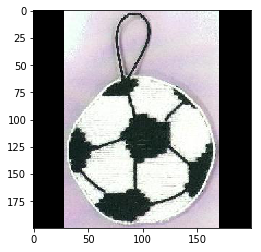

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(imgs_np[300])

### Generate Features from Images in Dataset

Run the below code block if you are not using a GPU-based machine. It will take a subset of the data so that the feature extraction process will be faster. 

In [ ]:
# If you are not using a GPU machine, run the below line to take a subset of the data. 
imgs_np = imgs_np[:1000]
imgs_np.shape

Extract features from the images, using a pretrained model. 
Possible values for the pretrained_model parameter are 'resnet50', 'inception_v3' and 'vgg19'. The output of the below function is the embeddings (vectors) generated from the images. 

In [119]:
embeddings = extract_features(imgs_np, pretrained_model="vgg19")

Input images shape:  (9144, 64, 64, 3)
80142336/80134624 [==============================] - 2s 0us/step
Features shape:  (9144, 512)


Show the embedding of the first image in the dataset

In [118]:
embeddings[0]

array([0.        , 1.4380319 , 0.        , ..., 1.0015441 , 0.41706264,
       4.840535  ], dtype=float32)

### Save and Load Embeddings to/from .npy file

Saving embeddings into a .npy file will help to load the prepared data back in much quicker when needed. 

In [132]:
np.save('caltech101_np_4096d.npy', embeddings) # Save the embeddings to .npy
np.save('caltech101_np_4096d_filenames.npy', filenames) # Save the filenames to .npy

In [133]:
arr = np.load('caltech101_np_4096d.npy') # Load in the saved embeddings into the notebook
filenames = np.load('caltech101_np_4096d_filenames.npy') # Load in the saved filenames into the notebook

Prepare the full array of embeddings we will be indexing

In [125]:
xb = arr.astype('float32') # embeddings dataset
xb.shape

(9144, 512)

### Select a Query Vector

Select an embedding in the dataset - this embedding will be the test embedding that we will run the similarity search again later on. 

In [127]:
xq = xb[3:4] # The 3rd image in the dataset will be selected
xq.shape 

(1, 512)

### Build the Index using SPTAG

Now, we will build the index using SPTAG, with the embeddings you generated using the Caltech101 images. The testBuild method will also save the built index so that it can be reused later. 

In [128]:
algo = 'KDT' # or BKT
distmethod = 'L2'
%time testBuild(algo, distmethod, xb, 'sptag_indice')

CPU times: user 21min 14s, sys: 1.76 s, total: 21min 16s
Wall time: 11min 3s


### Query for k Most Similar Images

Perform a similarity search against the query vector which we picked earlier. 

In [130]:
# Number of results to return, in this case the 5 most similar results
k = 5 

# query sptag index, using the same method we defined earlier
%time search_result = testSearch('sptag_indice', xq, k)

print(search_result[0][0]) # index
print(search_result[0][1]) # distance

CPU times: user 18.5 ms, sys: 3.99 ms, total: 22.5 ms
Wall time: 22.5 ms
[3, 3830, 6784, 6763, 6752]
[0.0, 28712.98046875, 28897.927734375, 31872.806640625, 33766.98046875]


### Visualize Search Results - k Most Similar Images

Display the results of the image similarity search performed above.

([3, 3830, 6784, 6763, 6752], [0.0, 28712.98046875, 28897.927734375, 31872.806640625, 33766.98046875], [<NULL>, <NULL>, <NULL>, <NULL>, <NULL>])
image index : 3
image distance : 0.0
image file : 101_ObjectCategories/umbrella/image_0030.jpg
image index : 3830
image distance : 28712.98046875
image file : 101_ObjectCategories/dragonfly/image_0036.jpg
image index : 6784
image distance : 28897.927734375
image file : 101_ObjectCategories/brain/image_0048.jpg
image index : 6763
image distance : 31872.806640625
image file : 101_ObjectCategories/brain/image_0007.jpg
image index : 6752
image distance : 33766.98046875
image file : 101_ObjectCategories/brain/image_0001.jpg


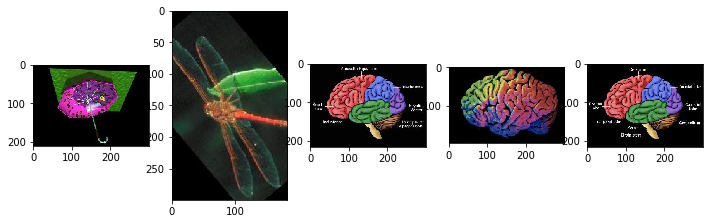

In [153]:
def draw_image5(img_indexes):
    print(img_indexes)
    w=10
    h=10
    fig=plt.figure(figsize=(12, 12))
    columns = 5
    rows = 1
    for i in range(1, columns*rows +1):
        print('image index : ' + str(img_indexes[0][i-1]))
        print('image distance : ' + str(img_indexes[1][i-1]))
        
        print('image file : ' + filenames[img_indexes[0][i-1]])
        p_img = Image.open(filenames[img_indexes[0]][i-1])
        img =  np.array(p_img) 
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()
    
draw_image5(search_result[0])